In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import pickle
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


In [36]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [37]:
# dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
#            "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
#            "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
#            "soil" : pd.read_csv("../src/soil_data.csv"),
#            }

In [38]:
# dataDic["train"].columns

In [39]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [40]:
# dfs = {
#     k: dataDic[k].set_index(['fips', 'date'])
#     for k in dataDic.keys() if k != "soil"
# }

# dfs["soil"] = dataDic["soil"]

In [41]:
batch_size = 128
output_weeks = 6
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
embeddings_dim = [20, 20, 20, 20, 20, 20, 20, 570]
dropout = 0.3
lr = 9e-5
epochs = 15
clip = 5


In [42]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

In [43]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

In [44]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [45]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [46]:
# actual path
original_path = os.getcwd()
os.chdir('/home/juagudelo/HOMEdev/drought_pred_hybrid/')

In [47]:
import utilities
import models

In [48]:
# Importing the list of unique categories for the categorical features
with open(f"data/processed_dataFrames/list_cat.pickle", "rb") as f:
    list_cat = pickle.load(f)

In [49]:
# Setting up the loaders
dfs=utilities.load_dataFrames()
train_loader=utilities.create_dataLoader(X_time=dfs["X_time_train"],
                                         X_static=dfs["X_tabular_train"],
                                         X_static_cat=dfs["X_tabular_cat_train"],
                                         y_target=dfs["y_target_train"],
                                         output_weeks=output_weeks,
                                         y_past=None,
                                         batch_size=128,
                                         shuffle=True
                                         )
valid_loader=utilities.create_dataLoader(X_time=dfs["X_time_valid"],
                                         X_static=dfs["X_tabular_valid"],
                                         X_static_cat=dfs["X_tabular_cat_valid"],
                                         y_target=dfs["y_target_valid"],
                                         output_weeks=output_weeks,
                                         y_past=None,
                                         batch_size=128,
                                         shuffle=False
                                         )
test_loader=utilities.create_dataLoader(X_time=dfs["X_time_test"],
                                        X_static=dfs["X_tabular_test"],
                                        X_static_cat=dfs["X_tabular_cat_test"],
                                        y_target=dfs["y_target_test"],
                                        output_weeks=output_weeks,
                                        y_past=None,
                                        batch_size=128,
                                        shuffle=False
                                        )


In [50]:
list_cat

[8, 8, 8, 8, 8, 7, 9, 3110]

In [51]:
print(embeddings_dim)

[20, 20, 20, 20, 20, 20, 20, 570]


In [52]:
os.chdir(original_path)

In [53]:
class HybridModel(nn.Module):
    def __init__(
        self,
        num_numerical_features,
        num_time_series_features,
        hidden_size,
        num_lstm_layers,
        list_unic_cat,
        embedding_dims,
        num_fc_tabular_layers,
        num_fc_combined_layers,
        output_size,
        dropout
    ):
        super(HybridModel, self).__init__()
        self.num_lstm_layers = num_lstm_layers
        self.hidden_size = hidden_size

        self.embeddings = nn.ModuleList(
                [
                    nn.Embedding(num_embeddings=i, embedding_dim=dimension)
                    for i, dimension in zip(list_unic_cat, embedding_dims)
                ]
            )
        
        tabular_total_size = num_numerical_features + sum(embedding_dims)
        tabular_fc_layers = []
        for _ in range(num_fc_tabular_layers):
            tabular_fc_layers.append(nn.Linear(tabular_total_size, tabular_total_size))
            tabular_fc_layers.append(nn.ReLU())
        self.tabular_fc_layers = nn.Sequential(
            *tabular_fc_layers, nn.Linear(tabular_total_size, tabular_total_size)
        )

        # TS branch
        self.lstm = nn.LSTM(
            input_size=num_time_series_features,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.attention = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

        combined_fc_layers = []
        input_dim = tabular_total_size + hidden_size

        for _ in range(num_fc_combined_layers):
            combined_fc_layers.append(nn.Linear(input_dim, hidden_size))
            combined_fc_layers.append(nn.ReLU())
            input_dim = hidden_size
        self.combined_fc_layers = nn.Sequential(
            *combined_fc_layers, nn.Linear(hidden_size, output_size)
        )

    def forward(self, time_series_data, numerical_data, categorical_data):
        batch_size = time_series_data.size(0)
        h0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)

        time_series_data = time_series_data.to(torch.float32)
        numerical_data = numerical_data.to(torch.float32)
        categorical_data = categorical_data.to(torch.int64)

        embeddings = [emb(categorical_data[:, i]) for i, emb in enumerate(self.embeddings)]
        x_cat = torch.cat(embeddings, dim=1)
        x_tabular = torch.cat((x_cat, numerical_data), dim=1)
        x1 = self.tabular_fc_layers(x_tabular)

        # Pass the time series data through the LSTM and the attention mechanism
        lstm_out, _ = self.lstm(time_series_data, (h0, c0))
        lstm_out = self.layer_norm(lstm_out) # Apply layer normalization
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        # Pass the data through the attention mechanism
        # context_vector = lstm_out[:, -1, :]  # Last time step output

        # Combined MLPs and output
        x2 = self.dropout(context_vector)
        x = torch.cat((x1, x2), dim=1)
        x = self.combined_fc_layers(x)
        return x

In [54]:
model = HybridModel(
    num_numerical_features=dfs["X_tabular_train"].shape[-1],
    num_time_series_features=dfs["X_time_train"].shape[-1],
    hidden_size=hidden_dim,
    list_unic_cat=list_cat,
    embedding_dims=embeddings_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

In [55]:
# model.embeddings[0](torch.tensor(0))

In [56]:
# emb_out = [emb(torch.tensor([0,0,0,0,0,0,0,0])[i]) for i, emb in enumerate(model.embeddings)]

In [57]:
# emb_out[-1]

In [58]:
writer = SummaryWriter('../runs/otro_hybrido')

In [59]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")

model = HybridModel(
    num_numerical_features=dfs["X_tabular_train"].shape[-1],
    num_time_series_features=dfs["X_time_train"].shape[-1],
    hidden_size=hidden_dim,
    list_unic_cat=list_cat,
    embedding_dims=embeddings_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

model.to(device)
loss_function = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)

for i in range(epochs):
    for k, (inputs, static, static_cat, labels) in tqdm(enumerate(train_loader),
                                                       desc=f"epoch {i+1}/{epochs}",
                                                       total=len(train_loader),):
        model.train()
        counter += 1
        inputs, labels, static, static_cat = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
            static_cat.to(device),
        )
        
        model.zero_grad()
        output = model(inputs, static, static_cat)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, stat_cat, lab in valid_loader:
                    inp, lab, stat, stat_cat = inp.to(device), lab.to(device), stat.to(device), stat_cat.to(device)
                    out = model(inp, stat, stat_cat)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(MSE)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "../models/otro_hybrido.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/15:  50%|█████     | 380/759 [02:16<09:19,  1.48s/it]

{'loss': 0.744269847869873, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 1, 'validation_loss': np.float64(0.6206143446266651), 'macro_f1': np.float64(0.2546838454186907), 'micro_f1': np.float64(0.5873015873015873), 'mae': np.float64(0.5401053478422635)}
{'loss': 0.744269847869873, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 2, 'validation_loss': np.float64(0.6206143446266651), 'macro_f1': np.float64(0.22230895383994972), 'micro_f1': np.float64(0.5413105413105413), 'mae': np.float64(0.5961072419962524)}
{'loss': 0.744269847869873, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 3, 'validation_loss': np.float64(0.6206143446266651), 'macro_f1': np.float64(0.22583692446397008), 'micro_f1': np.float64(0.5502645502645502), 'mae': np.float64(0.5846690410143998)}
{'loss': 0.744269847869873, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 4, 'validation_loss': np.fl

epoch 1/15: 100%|██████████| 759/759 [04:33<00:00,  2.77it/s]


{'loss': 0.47120463848114014, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 1, 'validation_loss': np.float64(0.4325468365103006), 'macro_f1': np.float64(0.39580287618015747), 'micro_f1': np.float64(0.71998371998372), 'mae': np.float64(0.35678271156774793)}
{'loss': 0.47120463848114014, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 2, 'validation_loss': np.float64(0.4325468365103006), 'macro_f1': np.float64(0.39296098048011235), 'micro_f1': np.float64(0.7098087098087098), 'mae': np.float64(0.3812712867992828)}
{'loss': 0.47120463848114014, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 3, 'validation_loss': np.float64(0.4325468365103006), 'macro_f1': np.float64(0.37203661440235525), 'micro_f1': np.float64(0.7032967032967034), 'mae': np.float64(0.40539789977023677)}
{'loss': 0.47120463848114014, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 4, 'validation_loss': np.float64(0.4325468365103006), 'macro_f1': np.float

epoch 2/15:  50%|█████     | 380/759 [02:18<09:25,  1.49s/it]

{'loss': 0.5358663201332092, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 1, 'validation_loss': np.float64(0.41692803874611856), 'macro_f1': np.float64(0.49297725807681125), 'micro_f1': np.float64(0.7260887260887261), 'mae': np.float64(0.34720040108259587)}
{'loss': 0.5358663201332092, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 2, 'validation_loss': np.float64(0.41692803874611856), 'macro_f1': np.float64(0.49253366429032264), 'micro_f1': np.float64(0.7195767195767195), 'mae': np.float64(0.3712260819198586)}
{'loss': 0.5358663201332092, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 3, 'validation_loss': np.float64(0.41692803874611856), 'macro_f1': np.float64(0.47566248431342695), 'micro_f1': np.float64(0.7118437118437119), 'mae': np.float64(0.3929877813603832)}
{'loss': 0.5358663201332092, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 4, 'validation

epoch 2/15: 100%|██████████| 759/759 [04:36<00:00,  2.75it/s]


{'loss': 0.6049270629882812, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 1, 'validation_loss': np.float64(0.5180811796337366), 'macro_f1': np.float64(0.492474264943001), 'micro_f1': np.float64(0.684981684981685), 'mae': np.float64(0.43008700045416265)}
{'loss': 0.6049270629882812, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 2, 'validation_loss': np.float64(0.5180811796337366), 'macro_f1': np.float64(0.46893625960995927), 'micro_f1': np.float64(0.6634106634106635), 'mae': np.float64(0.45997944384570527)}
{'loss': 0.6049270629882812, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 3, 'validation_loss': np.float64(0.5180811796337366), 'macro_f1': np.float64(0.44429503950101074), 'micro_f1': np.float64(0.6516076516076517), 'mae': np.float64(0.4792614055923379)}
{'loss': 0.6049270629882812, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 4, 'validation_loss': np.float64(0.5180811796337366), 'macro_f1': np.float64(0.

epoch 3/15:  50%|█████     | 380/759 [02:18<09:24,  1.49s/it]

{'loss': 0.3704349994659424, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 1, 'validation_loss': np.float64(0.3238883730024099), 'macro_f1': np.float64(0.5351168482338698), 'micro_f1': np.float64(0.7610907610907611), 'mae': np.float64(0.29282999396403037)}
{'loss': 0.3704349994659424, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 2, 'validation_loss': np.float64(0.3238883730024099), 'macro_f1': np.float64(0.5163478839363786), 'micro_f1': np.float64(0.7533577533577533), 'mae': np.float64(0.3100804417259729)}
{'loss': 0.3704349994659424, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 3, 'validation_loss': np.float64(0.3238883730024099), 'macro_f1': np.float64(0.5240451508567823), 'micro_f1': np.float64(0.7545787545787546), 'mae': np.float64(0.324250109843621)}
{'loss': 0.3704349994659424, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 4, 'validation_loss':

epoch 3/15: 100%|██████████| 759/759 [04:35<00:00,  2.75it/s]


{'loss': 0.559748113155365, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 1, 'validation_loss': np.float64(0.22730424162000418), 'macro_f1': np.float64(0.633885336667103), 'micro_f1': np.float64(0.8213268213268213), 'mae': np.float64(0.22681053205534676)}
{'loss': 0.559748113155365, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 2, 'validation_loss': np.float64(0.22730424162000418), 'macro_f1': np.float64(0.6202788493507837), 'micro_f1': np.float64(0.807895807895808), 'mae': np.float64(0.24662069616555762)}
{'loss': 0.559748113155365, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 3, 'validation_loss': np.float64(0.22730424162000418), 'macro_f1': np.float64(0.5590732197804269), 'micro_f1': np.float64(0.7944647944647945), 'mae': np.float64(0.2653290997486067)}
{'loss': 0.559748113155365, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 4, 'validation_loss': np.float64(0.22730424162000418), 'macro_f1': np.float64(0.54

epoch 4/15:  50%|█████     | 380/759 [02:18<09:23,  1.49s/it]

{'loss': 0.3425055742263794, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 1, 'validation_loss': np.float64(0.19329215437173844), 'macro_f1': np.float64(0.6569025462201373), 'micro_f1': np.float64(0.8461538461538461), 'mae': np.float64(0.18382226023772977)}
{'loss': 0.3425055742263794, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 2, 'validation_loss': np.float64(0.19329215437173844), 'macro_f1': np.float64(0.6389374230268586), 'micro_f1': np.float64(0.8306878306878307), 'mae': np.float64(0.21370680933592875)}
{'loss': 0.3425055742263794, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 3, 'validation_loss': np.float64(0.19329215437173844), 'macro_f1': np.float64(0.5864770609981559), 'micro_f1': np.float64(0.8021978021978022), 'mae': np.float64(0.2367571717746084)}
{'loss': 0.3425055742263794, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 4, 'validation_loss'

epoch 4/15: 100%|██████████| 759/759 [04:35<00:00,  2.75it/s]


{'loss': 0.22084222733974457, 'epoch': 4.0, 'step': 3036, 'lr': 8.740679149978162e-05, 'week': 1, 'validation_loss': np.float64(0.18387237712740898), 'macro_f1': np.float64(0.6859744363951087), 'micro_f1': np.float64(0.8563288563288564), 'mae': np.float64(0.17041199741443464)}
{'loss': 0.22084222733974457, 'epoch': 4.0, 'step': 3036, 'lr': 8.740679149978162e-05, 'week': 2, 'validation_loss': np.float64(0.18387237712740898), 'macro_f1': np.float64(0.6743524027414821), 'micro_f1': np.float64(0.8327228327228328), 'mae': np.float64(0.2068248343096112)}
{'loss': 0.22084222733974457, 'epoch': 4.0, 'step': 3036, 'lr': 8.740679149978162e-05, 'week': 3, 'validation_loss': np.float64(0.18387237712740898), 'macro_f1': np.float64(0.597519567037386), 'micro_f1': np.float64(0.8066748066748066), 'mae': np.float64(0.23376661533669504)}
{'loss': 0.22084222733974457, 'epoch': 4.0, 'step': 3036, 'lr': 8.740679149978162e-05, 'week': 4, 'validation_loss': np.float64(0.18387237712740898), 'macro_f1': np.flo

epoch 5/15:  50%|█████     | 380/759 [02:18<09:33,  1.51s/it]

{'loss': 0.28995007276535034, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 8.999999213314978e-05, 'week': 1, 'validation_loss': np.float64(0.18628232851624488), 'macro_f1': np.float64(0.6327396724614326), 'micro_f1': np.float64(0.846967846967847), 'mae': np.float64(0.1689933130826639)}
{'loss': 0.28995007276535034, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 8.999999213314978e-05, 'week': 2, 'validation_loss': np.float64(0.18628232851624488), 'macro_f1': np.float64(0.6087710632300432), 'micro_f1': np.float64(0.8262108262108262), 'mae': np.float64(0.20639794698116015)}
{'loss': 0.28995007276535034, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 8.999999213314978e-05, 'week': 3, 'validation_loss': np.float64(0.18628232851624488), 'macro_f1': np.float64(0.5779143345588977), 'micro_f1': np.float64(0.8054538054538054), 'mae': np.float64(0.24429553741370869)}
{'loss': 0.28995007276535034, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 8.999999213314978e-05, 'week': 4, 'validation_lo

epoch 5/15: 100%|██████████| 759/759 [04:35<00:00,  2.75it/s]


{'loss': 0.3028032183647156, 'epoch': 5.0, 'step': 3795, 'lr': 8.949474186988228e-05, 'week': 1, 'validation_loss': np.float64(0.18654615581035613), 'macro_f1': np.float64(0.7037876420162806), 'micro_f1': np.float64(0.8726088726088727), 'mae': np.float64(0.1659346984822032)}
{'loss': 0.3028032183647156, 'epoch': 5.0, 'step': 3795, 'lr': 8.949474186988228e-05, 'week': 2, 'validation_loss': np.float64(0.18654615581035613), 'macro_f1': np.float64(0.6676112802679), 'micro_f1': np.float64(0.8408628408628409), 'mae': np.float64(0.2032946709497128)}
{'loss': 0.3028032183647156, 'epoch': 5.0, 'step': 3795, 'lr': 8.949474186988228e-05, 'week': 3, 'validation_loss': np.float64(0.18654615581035613), 'macro_f1': np.float64(0.626481620667271), 'micro_f1': np.float64(0.814000814000814), 'mae': np.float64(0.23261044921303436)}
{'loss': 0.3028032183647156, 'epoch': 5.0, 'step': 3795, 'lr': 8.949474186988228e-05, 'week': 4, 'validation_loss': np.float64(0.18654615581035613), 'macro_f1': np.float64(0.61

epoch 6/15:  50%|█████     | 380/759 [02:18<09:23,  1.49s/it]

{'loss': 0.2751064896583557, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 8.799293373936494e-05, 'week': 1, 'validation_loss': np.float64(0.16972602624446154), 'macro_f1': np.float64(0.6953014173775025), 'micro_f1': np.float64(0.8705738705738706), 'mae': np.float64(0.16053233587014418)}
{'loss': 0.2751064896583557, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 8.799293373936494e-05, 'week': 2, 'validation_loss': np.float64(0.16972602624446154), 'macro_f1': np.float64(0.6784992420916511), 'micro_f1': np.float64(0.8441188441188441), 'mae': np.float64(0.20021118994012488)}
{'loss': 0.2751064896583557, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 8.799293373936494e-05, 'week': 3, 'validation_loss': np.float64(0.16972602624446154), 'macro_f1': np.float64(0.6489207041043655), 'micro_f1': np.float64(0.8233618233618234), 'mae': np.float64(0.2299455356247888)}
{'loss': 0.2751064896583557, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 8.799293373936494e-05, 'week': 4, 'validation_loss'

epoch 6/15: 100%|██████████| 759/759 [04:35<00:00,  2.75it/s]


{'loss': 0.24610142409801483, 'epoch': 6.0, 'step': 4554, 'lr': 8.553591705982761e-05, 'week': 1, 'validation_loss': np.float64(0.20426808968186377), 'macro_f1': np.float64(0.7163694326823586), 'micro_f1': np.float64(0.8669108669108669), 'mae': np.float64(0.15470530069597505)}
{'loss': 0.24610142409801483, 'epoch': 6.0, 'step': 4554, 'lr': 8.553591705982761e-05, 'week': 2, 'validation_loss': np.float64(0.20426808968186377), 'macro_f1': np.float64(0.665850496458745), 'micro_f1': np.float64(0.8363858363858364), 'mae': np.float64(0.1980400626125185)}
{'loss': 0.24610142409801483, 'epoch': 6.0, 'step': 4554, 'lr': 8.553591705982761e-05, 'week': 3, 'validation_loss': np.float64(0.20426808968186377), 'macro_f1': np.float64(0.6214675916744243), 'micro_f1': np.float64(0.8091168091168092), 'mae': np.float64(0.23791213094311223)}
{'loss': 0.24610142409801483, 'epoch': 6.0, 'step': 4554, 'lr': 8.553591705982761e-05, 'week': 4, 'validation_loss': np.float64(0.20426808968186377), 'macro_f1': np.flo

epoch 7/15:  50%|█████     | 380/759 [02:18<09:32,  1.51s/it]

{'loss': 0.2516704201698303, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 8.216578050524531e-05, 'week': 1, 'validation_loss': np.float64(0.19646446350961924), 'macro_f1': np.float64(0.7275448454598564), 'micro_f1': np.float64(0.870980870980871), 'mae': np.float64(0.1510107646529032)}
{'loss': 0.2516704201698303, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 8.216578050524531e-05, 'week': 2, 'validation_loss': np.float64(0.19646446350961924), 'macro_f1': np.float64(0.662647878923624), 'micro_f1': np.float64(0.8343508343508343), 'mae': np.float64(0.19295250314872903)}
{'loss': 0.2516704201698303, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 8.216578050524531e-05, 'week': 3, 'validation_loss': np.float64(0.19646446350961924), 'macro_f1': np.float64(0.6259356361493685), 'micro_f1': np.float64(0.8127798127798128), 'mae': np.float64(0.23322082812626474)}
{'loss': 0.2516704201698303, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 8.216578050524531e-05, 'week': 4, 'validation_loss': 

epoch 7/15: 100%|██████████| 759/759 [04:35<00:00,  2.75it/s]


{'loss': 0.31041964888572693, 'epoch': 7.0, 'step': 5313, 'lr': 7.797531412385515e-05, 'week': 1, 'validation_loss': np.float64(0.21107805538922547), 'macro_f1': np.float64(0.6033292516174307), 'micro_f1': np.float64(0.8628408628408628), 'mae': np.float64(0.16337581102124876)}
{'loss': 0.31041964888572693, 'epoch': 7.0, 'step': 5313, 'lr': 7.797531412385515e-05, 'week': 2, 'validation_loss': np.float64(0.21107805538922547), 'macro_f1': np.float64(0.5571380086996226), 'micro_f1': np.float64(0.8388278388278388), 'mae': np.float64(0.19667515241645964)}
{'loss': 0.31041964888572693, 'epoch': 7.0, 'step': 5313, 'lr': 7.797531412385515e-05, 'week': 3, 'validation_loss': np.float64(0.21107805538922547), 'macro_f1': np.float64(0.497012836599749), 'micro_f1': np.float64(0.807895807895808), 'mae': np.float64(0.2339484014209)}
{'loss': 0.31041964888572693, 'epoch': 7.0, 'step': 5313, 'lr': 7.797531412385515e-05, 'week': 4, 'validation_loss': np.float64(0.21107805538922547), 'macro_f1': np.float64

epoch 8/15:  50%|█████     | 380/759 [02:18<09:23,  1.49s/it]

{'loss': 0.2233419269323349, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 7.303630056768322e-05, 'week': 1, 'validation_loss': np.float64(0.16142112836241723), 'macro_f1': np.float64(0.687887093763437), 'micro_f1': np.float64(0.8888888888888888), 'mae': np.float64(0.1317601186553971)}
{'loss': 0.2233419269323349, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 7.303630056768322e-05, 'week': 2, 'validation_loss': np.float64(0.16142112836241723), 'macro_f1': np.float64(0.6534166786356509), 'micro_f1': np.float64(0.8591778591778592), 'mae': np.float64(0.17323108731553347)}
{'loss': 0.2233419269323349, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 7.303630056768322e-05, 'week': 3, 'validation_loss': np.float64(0.16142112836241723), 'macro_f1': np.float64(0.604862498129508), 'micro_f1': np.float64(0.8323158323158323), 'mae': np.float64(0.20720755875262636)}
{'loss': 0.2233419269323349, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 7.303630056768322e-05, 'week': 4, 'validation_loss': 

epoch 8/15: 100%|██████████| 759/759 [04:35<00:00,  2.75it/s]


{'loss': 0.29132845997810364, 'epoch': 8.0, 'step': 6072, 'lr': 6.748472581198555e-05, 'week': 1, 'validation_loss': np.float64(0.1765194868668914), 'macro_f1': np.float64(0.7318049814290415), 'micro_f1': np.float64(0.8791208791208791), 'mae': np.float64(0.15419388154316507)}
{'loss': 0.29132845997810364, 'epoch': 8.0, 'step': 6072, 'lr': 6.748472581198555e-05, 'week': 2, 'validation_loss': np.float64(0.1765194868668914), 'macro_f1': np.float64(0.6760953382650446), 'micro_f1': np.float64(0.8424908424908425), 'mae': np.float64(0.19560611145829576)}
{'loss': 0.29132845997810364, 'epoch': 8.0, 'step': 6072, 'lr': 6.748472581198555e-05, 'week': 3, 'validation_loss': np.float64(0.1765194868668914), 'macro_f1': np.float64(0.6390190612771832), 'micro_f1': np.float64(0.8196988196988197), 'mae': np.float64(0.2382118382952361)}
{'loss': 0.29132845997810364, 'epoch': 8.0, 'step': 6072, 'lr': 6.748472581198555e-05, 'week': 4, 'validation_loss': np.float64(0.1765194868668914), 'macro_f1': np.float6

epoch 9/15:  50%|█████     | 380/759 [02:18<09:18,  1.47s/it]

{'loss': 0.1795581430196762, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 6.141568828319385e-05, 'week': 1, 'validation_loss': np.float64(0.16429286636412144), 'macro_f1': np.float64(0.7537110714089214), 'micro_f1': np.float64(0.8876678876678876), 'mae': np.float64(0.13486547073061267)}
{'loss': 0.1795581430196762, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 6.141568828319385e-05, 'week': 2, 'validation_loss': np.float64(0.16429286636412144), 'macro_f1': np.float64(0.6913400111809685), 'micro_f1': np.float64(0.8595848595848596), 'mae': np.float64(0.17272739429863593)}
{'loss': 0.1795581430196762, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 6.141568828319385e-05, 'week': 3, 'validation_loss': np.float64(0.16429286636412144), 'macro_f1': np.float64(0.630444453729606), 'micro_f1': np.float64(0.8286528286528286), 'mae': np.float64(0.21224610853676062)}
{'loss': 0.1795581430196762, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 6.141568828319385e-05, 'week': 4, 'validation_loss'

epoch 9/15: 100%|██████████| 759/759 [04:36<00:00,  2.75it/s]


{'loss': 0.27281150221824646, 'epoch': 9.0, 'step': 6831, 'lr': 5.4996286932916974e-05, 'week': 1, 'validation_loss': np.float64(0.16155139822512865), 'macro_f1': np.float64(0.7323464903703378), 'micro_f1': np.float64(0.877085877085877), 'mae': np.float64(0.15237385634734674)}
{'loss': 0.27281150221824646, 'epoch': 9.0, 'step': 6831, 'lr': 5.4996286932916974e-05, 'week': 2, 'validation_loss': np.float64(0.16155139822512865), 'macro_f1': np.float64(0.6978575012154503), 'micro_f1': np.float64(0.8490028490028491), 'mae': np.float64(0.18554235467653893)}
{'loss': 0.27281150221824646, 'epoch': 9.0, 'step': 6831, 'lr': 5.4996286932916974e-05, 'week': 3, 'validation_loss': np.float64(0.16155139822512865), 'macro_f1': np.float64(0.6503024138180517), 'micro_f1': np.float64(0.8319088319088319), 'mae': np.float64(0.21695264263060768)}
{'loss': 0.27281150221824646, 'epoch': 9.0, 'step': 6831, 'lr': 5.4996286932916974e-05, 'week': 4, 'validation_loss': np.float64(0.16155139822512865), 'macro_f1': n

epoch 10/15:  50%|█████     | 380/759 [02:18<09:19,  1.48s/it]

{'loss': 0.2443629503250122, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 4.8336486049471124e-05, 'week': 1, 'validation_loss': np.float64(0.17211250253021718), 'macro_f1': np.float64(0.7566140892165918), 'micro_f1': np.float64(0.8868538868538869), 'mae': np.float64(0.1346902966829403)}
{'loss': 0.2443629503250122, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 4.8336486049471124e-05, 'week': 2, 'validation_loss': np.float64(0.17211250253021718), 'macro_f1': np.float64(0.7268973016497116), 'micro_f1': np.float64(0.8559218559218559), 'mae': np.float64(0.1760518655309713)}
{'loss': 0.2443629503250122, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 4.8336486049471124e-05, 'week': 3, 'validation_loss': np.float64(0.17211250253021718), 'macro_f1': np.float64(0.6512447154861059), 'micro_f1': np.float64(0.8278388278388278), 'mae': np.float64(0.2131999072470841)}
{'loss': 0.2443629503250122, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 4.8336486049471124e-05, 'week': 4, 'validation_los

epoch 10/15: 100%|██████████| 759/759 [04:36<00:00,  2.75it/s]


{'loss': 0.28533700108528137, 'epoch': 10.0, 'step': 7590, 'lr': 4.161965008566596e-05, 'week': 1, 'validation_loss': np.float64(0.15708745662122964), 'macro_f1': np.float64(0.7228630928395544), 'micro_f1': np.float64(0.892958892958893), 'mae': np.float64(0.1234028687936131)}
{'loss': 0.28533700108528137, 'epoch': 10.0, 'step': 7590, 'lr': 4.161965008566596e-05, 'week': 2, 'validation_loss': np.float64(0.15708745662122964), 'macro_f1': np.float64(0.6930902122440125), 'micro_f1': np.float64(0.8616198616198616), 'mae': np.float64(0.1625013395765433)}
{'loss': 0.28533700108528137, 'epoch': 10.0, 'step': 7590, 'lr': 4.161965008566596e-05, 'week': 3, 'validation_loss': np.float64(0.15708745662122964), 'macro_f1': np.float64(0.6149896740442384), 'micro_f1': np.float64(0.8319088319088319), 'mae': np.float64(0.20152866783849058)}
{'loss': 0.28533700108528137, 'epoch': 10.0, 'step': 7590, 'lr': 4.161965008566596e-05, 'week': 4, 'validation_loss': np.float64(0.15708745662122964), 'macro_f1': np.

epoch 11/15:  50%|█████     | 380/759 [02:18<09:25,  1.49s/it]

{'loss': 0.1832113116979599, 'epoch': 10.500658761528326, 'step': 7970, 'lr': 3.496083838211498e-05, 'week': 1, 'validation_loss': np.float64(0.1523095266893506), 'macro_f1': np.float64(0.7592981088607492), 'micro_f1': np.float64(0.8913308913308914), 'mae': np.float64(0.12389255910387079)}
{'loss': 0.1832113116979599, 'epoch': 10.500658761528326, 'step': 7970, 'lr': 3.496083838211498e-05, 'week': 2, 'validation_loss': np.float64(0.1523095266893506), 'macro_f1': np.float64(0.686111135637062), 'micro_f1': np.float64(0.8555148555148555), 'mae': np.float64(0.16467354378292862)}
{'loss': 0.1832113116979599, 'epoch': 10.500658761528326, 'step': 7970, 'lr': 3.496083838211498e-05, 'week': 3, 'validation_loss': np.float64(0.1523095266893506), 'macro_f1': np.float64(0.5902815333866488), 'micro_f1': np.float64(0.8278388278388278), 'mae': np.float64(0.20535354684824178)}
{'loss': 0.1832113116979599, 'epoch': 10.500658761528326, 'step': 7970, 'lr': 3.496083838211498e-05, 'week': 4, 'validation_loss

epoch 11/15: 100%|██████████| 759/759 [04:35<00:00,  2.75it/s]


{'loss': 0.16981102526187897, 'epoch': 11.0, 'step': 8349, 'lr': 2.8543388156514706e-05, 'week': 1, 'validation_loss': np.float64(0.15087861139327288), 'macro_f1': np.float64(0.756773059314039), 'micro_f1': np.float64(0.8905168905168905), 'mae': np.float64(0.12245242922688494)}
{'loss': 0.16981102526187897, 'epoch': 11.0, 'step': 8349, 'lr': 2.8543388156514706e-05, 'week': 2, 'validation_loss': np.float64(0.15087861139327288), 'macro_f1': np.float64(0.6971648865212634), 'micro_f1': np.float64(0.8559218559218559), 'mae': np.float64(0.16297346212538993)}
{'loss': 0.16981102526187897, 'epoch': 11.0, 'step': 8349, 'lr': 2.8543388156514706e-05, 'week': 3, 'validation_loss': np.float64(0.15087861139327288), 'macro_f1': np.float64(0.6126378002745492), 'micro_f1': np.float64(0.8266178266178266), 'mae': np.float64(0.20099198645401165)}
{'loss': 0.16981102526187897, 'epoch': 11.0, 'step': 8349, 'lr': 2.8543388156514706e-05, 'week': 4, 'validation_loss': np.float64(0.15087861139327288), 'macro_f1

epoch 12/15:  50%|█████     | 380/759 [02:18<09:23,  1.49s/it]

{'loss': 0.2879689335823059, 'epoch': 11.500658761528326, 'step': 8729, 'lr': 2.2477230274432936e-05, 'week': 1, 'validation_loss': np.float64(0.14930898323655128), 'macro_f1': np.float64(0.769155643429405), 'micro_f1': np.float64(0.892958892958893), 'mae': np.float64(0.11908551750078067)}
{'loss': 0.2879689335823059, 'epoch': 11.500658761528326, 'step': 8729, 'lr': 2.2477230274432936e-05, 'week': 2, 'validation_loss': np.float64(0.14930898323655128), 'macro_f1': np.float64(0.7141979026061436), 'micro_f1': np.float64(0.8579568579568579), 'mae': np.float64(0.1597052911543532)}
{'loss': 0.2879689335823059, 'epoch': 11.500658761528326, 'step': 8729, 'lr': 2.2477230274432936e-05, 'week': 3, 'validation_loss': np.float64(0.14930898323655128), 'macro_f1': np.float64(0.6348822422087527), 'micro_f1': np.float64(0.833943833943834), 'mae': np.float64(0.1961136144988155)}
{'loss': 0.2879689335823059, 'epoch': 11.500658761528326, 'step': 8729, 'lr': 2.2477230274432936e-05, 'week': 4, 'validation_l

epoch 12/15: 100%|██████████| 759/759 [04:35<00:00,  2.75it/s]


{'loss': 0.21377672255039215, 'epoch': 12.0, 'step': 9108, 'lr': 1.6929384402098612e-05, 'week': 1, 'validation_loss': np.float64(0.15594332441687583), 'macro_f1': np.float64(0.7607628454260441), 'micro_f1': np.float64(0.892958892958893), 'mae': np.float64(0.12545400113965116)}
{'loss': 0.21377672255039215, 'epoch': 12.0, 'step': 9108, 'lr': 1.6929384402098612e-05, 'week': 2, 'validation_loss': np.float64(0.15594332441687583), 'macro_f1': np.float64(0.7143561206434527), 'micro_f1': np.float64(0.8547008547008547), 'mae': np.float64(0.16720509448087378)}
{'loss': 0.21377672255039215, 'epoch': 12.0, 'step': 9108, 'lr': 1.6929384402098612e-05, 'week': 3, 'validation_loss': np.float64(0.15594332441687583), 'macro_f1': np.float64(0.6513335582623186), 'micro_f1': np.float64(0.8245828245828246), 'mae': np.float64(0.2110730752542102)}
{'loss': 0.21377672255039215, 'epoch': 12.0, 'step': 9108, 'lr': 1.6929384402098612e-05, 'week': 4, 'validation_loss': np.float64(0.15594332441687583), 'macro_f1'

epoch 13/15:  50%|█████     | 380/759 [02:18<09:20,  1.48s/it]

{'loss': 0.2747109532356262, 'epoch': 12.500658761528326, 'step': 9488, 'lr': 1.1994885090204386e-05, 'week': 1, 'validation_loss': np.float64(0.1562358595430851), 'macro_f1': np.float64(0.7565403924114146), 'micro_f1': np.float64(0.8909238909238909), 'mae': np.float64(0.12311194317197013)}
{'loss': 0.2747109532356262, 'epoch': 12.500658761528326, 'step': 9488, 'lr': 1.1994885090204386e-05, 'week': 2, 'validation_loss': np.float64(0.1562358595430851), 'macro_f1': np.float64(0.7144962616466627), 'micro_f1': np.float64(0.8551078551078551), 'mae': np.float64(0.16447896660669636)}
{'loss': 0.2747109532356262, 'epoch': 12.500658761528326, 'step': 9488, 'lr': 1.1994885090204386e-05, 'week': 3, 'validation_loss': np.float64(0.1562358595430851), 'macro_f1': np.float64(0.6258335585514376), 'micro_f1': np.float64(0.824989824989825), 'mae': np.float64(0.20452992561968464)}
{'loss': 0.2747109532356262, 'epoch': 12.500658761528326, 'step': 9488, 'lr': 1.1994885090204386e-05, 'week': 4, 'validation_

epoch 13/15: 100%|██████████| 759/759 [04:36<00:00,  2.75it/s]


{'loss': 0.2543250024318695, 'epoch': 13.0, 'step': 9867, 'lr': 7.809594023213535e-06, 'week': 1, 'validation_loss': np.float64(0.15665601287037134), 'macro_f1': np.float64(0.7384180449344212), 'micro_f1': np.float64(0.8909238909238909), 'mae': np.float64(0.12475535930715426)}
{'loss': 0.2543250024318695, 'epoch': 13.0, 'step': 9867, 'lr': 7.809594023213535e-06, 'week': 2, 'validation_loss': np.float64(0.15665601287037134), 'macro_f1': np.float64(0.6745526060238428), 'micro_f1': np.float64(0.8526658526658527), 'mae': np.float64(0.1657450767148208)}
{'loss': 0.2543250024318695, 'epoch': 13.0, 'step': 9867, 'lr': 7.809594023213535e-06, 'week': 3, 'validation_loss': np.float64(0.15665601287037134), 'macro_f1': np.float64(0.5810973554223936), 'micro_f1': np.float64(0.8258038258038258), 'mae': np.float64(0.20660639263079641)}
{'loss': 0.2543250024318695, 'epoch': 13.0, 'step': 9867, 'lr': 7.809594023213535e-06, 'week': 4, 'validation_loss': np.float64(0.15665601287037134), 'macro_f1': np.fl

epoch 14/15:  50%|█████     | 380/759 [02:18<09:20,  1.48s/it]

{'loss': 0.19443076848983765, 'epoch': 13.500658761528326, 'step': 10247, 'lr': 4.445205200062238e-06, 'week': 1, 'validation_loss': np.float64(0.15714597553014756), 'macro_f1': np.float64(0.7665923859726104), 'micro_f1': np.float64(0.8925518925518926), 'mae': np.float64(0.12152941975355937)}
{'loss': 0.19443076848983765, 'epoch': 13.500658761528326, 'step': 10247, 'lr': 4.445205200062238e-06, 'week': 2, 'validation_loss': np.float64(0.15714597553014756), 'macro_f1': np.float64(0.7344575995328736), 'micro_f1': np.float64(0.8591778591778592), 'mae': np.float64(0.16404946914997776)}
{'loss': 0.19443076848983765, 'epoch': 13.500658761528326, 'step': 10247, 'lr': 4.445205200062238e-06, 'week': 3, 'validation_loss': np.float64(0.15714597553014756), 'macro_f1': np.float64(0.6694719941080584), 'micro_f1': np.float64(0.8294668294668295), 'mae': np.float64(0.20465480481736878)}
{'loss': 0.19443076848983765, 'epoch': 13.500658761528326, 'step': 10247, 'lr': 4.445205200062238e-06, 'week': 4, 'val

epoch 14/15: 100%|██████████| 759/759 [04:36<00:00,  2.75it/s]


{'loss': 0.1985800415277481, 'epoch': 14.0, 'step': 10626, 'lr': 1.9943504165642993e-06, 'week': 1, 'validation_loss': np.float64(0.15538989715278148), 'macro_f1': np.float64(0.7522570081223675), 'micro_f1': np.float64(0.8941798941798942), 'mae': np.float64(0.1209157622225906)}
{'loss': 0.1985800415277481, 'epoch': 14.0, 'step': 10626, 'lr': 1.9943504165642993e-06, 'week': 2, 'validation_loss': np.float64(0.15538989715278148), 'macro_f1': np.float64(0.7081073725060905), 'micro_f1': np.float64(0.8591778591778592), 'mae': np.float64(0.16328676220227267)}
{'loss': 0.1985800415277481, 'epoch': 14.0, 'step': 10626, 'lr': 1.9943504165642993e-06, 'week': 3, 'validation_loss': np.float64(0.15538989715278148), 'macro_f1': np.float64(0.6125688517019995), 'micro_f1': np.float64(0.8262108262108262), 'mae': np.float64(0.2037364523721641)}
{'loss': 0.1985800415277481, 'epoch': 14.0, 'step': 10626, 'lr': 1.9943504165642993e-06, 'week': 4, 'validation_loss': np.float64(0.15538989715278148), 'macro_f1'

epoch 15/15:  50%|█████     | 380/759 [02:18<09:19,  1.48s/it]

{'loss': 0.23764392733573914, 'epoch': 14.500658761528326, 'step': 11006, 'lr': 4.990127934700871e-07, 'week': 1, 'validation_loss': np.float64(0.15685839150100947), 'macro_f1': np.float64(0.7527301056255529), 'micro_f1': np.float64(0.8937728937728938), 'mae': np.float64(0.12166428068503392)}
{'loss': 0.23764392733573914, 'epoch': 14.500658761528326, 'step': 11006, 'lr': 4.990127934700871e-07, 'week': 2, 'validation_loss': np.float64(0.15685839150100947), 'macro_f1': np.float64(0.7065552129014305), 'micro_f1': np.float64(0.8579568579568579), 'mae': np.float64(0.1644732311868238)}
{'loss': 0.23764392733573914, 'epoch': 14.500658761528326, 'step': 11006, 'lr': 4.990127934700871e-07, 'week': 3, 'validation_loss': np.float64(0.15685839150100947), 'macro_f1': np.float64(0.6551596223984474), 'micro_f1': np.float64(0.8282458282458283), 'mae': np.float64(0.20562169254287455)}
{'loss': 0.23764392733573914, 'epoch': 14.500658761528326, 'step': 11006, 'lr': 4.990127934700871e-07, 'week': 4, 'vali

epoch 15/15: 100%|██████████| 759/759 [04:36<00:00,  2.75it/s]

{'loss': 0.1911574751138687, 'epoch': 15.0, 'step': 11385, 'lr': 3.6349637793541974e-10, 'week': 1, 'validation_loss': np.float64(0.15645208060741425), 'macro_f1': np.float64(0.7518612728174068), 'micro_f1': np.float64(0.8937728937728938), 'mae': np.float64(0.12162260822545441)}
{'loss': 0.1911574751138687, 'epoch': 15.0, 'step': 11385, 'lr': 3.6349637793541974e-10, 'week': 2, 'validation_loss': np.float64(0.15645208060741425), 'macro_f1': np.float64(0.7073602882584359), 'micro_f1': np.float64(0.8591778591778592), 'mae': np.float64(0.16397171067072994)}
{'loss': 0.1911574751138687, 'epoch': 15.0, 'step': 11385, 'lr': 3.6349637793541974e-10, 'week': 3, 'validation_loss': np.float64(0.15645208060741425), 'macro_f1': np.float64(0.6401003556446146), 'micro_f1': np.float64(0.8290598290598291), 'mae': np.float64(0.20486754548386446)}
{'loss': 0.1911574751138687, 'epoch': 15.0, 'step': 11385, 'lr': 3.6349637793541974e-10, 'week': 4, 'validation_loss': np.float64(0.15645208060741425), 'macro_f

In [60]:
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = HybridModel(
    num_numerical_features=dfs["X_tabular_train"].shape[-1],
    num_time_series_features=dfs["X_time_train"].shape[-1],
    hidden_size=hidden_dim,
    list_unic_cat=list_cat,
    embedding_dims=embeddings_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

model.load_state_dict(torch.load("../models/otro_hybrido.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel(
  (embeddings): ModuleList(
    (0-4): 5 x Embedding(8, 20)
    (5): Embedding(7, 20)
    (6): Embedding(9, 20)
    (7): Embedding(3110, 570)
  )
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=732, out_features=732, bias=True)
    (1): ReLU()
    (2): Linear(in_features=732, out_features=732, bias=True)
    (3): ReLU()
    (4): Linear(in_features=732, out_features=732, bias=True)
  )
  (lstm): LSTM(40, 512, num_layers=2, batch_first=True, dropout=0.3)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=1244, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [61]:
def predict(x, static, static_cat):
    out = model(torch.tensor(x), static, static_cat)
    return out

In [74]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, static_cat, y in tqdm(
    valid_loader,# ou test_loader
    desc="validation predictions...",
    ):
    x, static, static_cat, y = x.to(device), static.to(device), static_cat.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static, static_cat).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1636175/1961147624.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(x), static, static_cat)
validation predictions...: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


In [75]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
VALIDATION_no_prev_year:
Week 1 MAE 0.137 F1 0.795
Week 2 MAE 0.201 F1 0.704
Week 3 MAE 0.257 F1 0.655
Week 4 MAE 0.309 F1 0.593
Week 5 MAE 0.354 F1 0.544
Week 6 MAE 0.393 F1 0.502

TEST_no_prev_year:
Week 1 MAE 0.147 F1 0.757
Week 2 MAE 0.203 F1 0.704
Week 3 MAE 0.256 F1 0.643
Week 4 MAE 0.307 F1 0.569
Week 5 MAE 0.355 F1 0.54
Week 6 MAE 0.396 F1 0.484

VALIDATION:
Week 1 MAE 0.131 F1 0.698
Week 2 MAE 0.171 F1 0.641
Week 3 MAE 0.207 F1 0.606
Week 4 MAE 0.242 F1 0.554
Week 5 MAE 0.271 F1 0.533
Week 6 MAE 0.304 F1 0.501
"""

Week 1 MAE 0.131 F1 0.698
Week 2 MAE 0.171 F1 0.641
Week 3 MAE 0.207 F1 0.606
Week 4 MAE 0.242 F1 0.554
Week 5 MAE 0.271 F1 0.533
Week 6 MAE 0.304 F1 0.501


'\nVALIDATION_no_prev_year:\nWeek 1 MAE 0.137 F1 0.795\nWeek 2 MAE 0.201 F1 0.704\nWeek 3 MAE 0.257 F1 0.655\nWeek 4 MAE 0.309 F1 0.593\nWeek 5 MAE 0.354 F1 0.544\nWeek 6 MAE 0.393 F1 0.502\n\nTEST_no_prev_year:\nWeek 1 MAE 0.147 F1 0.757\nWeek 2 MAE 0.203 F1 0.704\nWeek 3 MAE 0.256 F1 0.643\nWeek 4 MAE 0.307 F1 0.569\nWeek 5 MAE 0.355 F1 0.54\nWeek 6 MAE 0.396 F1 0.484\n'

In [64]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.121915,0,0.0000,0
1,-0.018850,0,0.0000,0
2,0.046769,0,0.0000,0
3,0.245430,0,0.0000,0
4,0.229178,0,0.0000,0
...,...,...,...,...
14857,2.723145,3,2.8139,5
14858,3.283614,3,3.1832,5
14859,2.766486,3,2.7126,5
14860,1.832863,2,2.0000,5


In [65]:
for cat in df["y_true"].round().astype(int).unique():
    df_cat = df[df["y_true"].round().astype(int) == cat]
    print(f"Accuracy {cat}:")
    print((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())

Accuracy 0:
0.8987719499598301
Accuracy 1:
0.49461979913916787
Accuracy 3:
0.486815415821501
Accuracy 4:
0.46123260437375746
Accuracy 2:
0.453125
Accuracy 5:
0.24305555555555555


In [66]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_squared_error

[np.float64(0.8987719499598301), np.float64(0.49461979913916787), np.float64(0.453125), np.float64(0.486815415821501), np.float64(0.46123260437375746), np.float64(0.24305555555555555)]


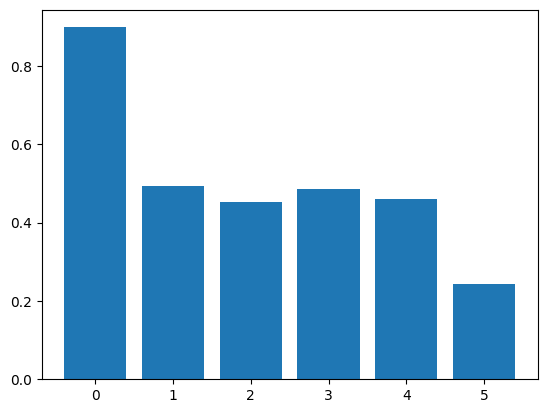

In [67]:
#accuracy bar plot for each category
accuracy = []
for cat in sorted(df["y_true"].round().astype(int).unique()):
    df_cat = df[df["y_true"].round().astype(int) == cat]
    accuracy.append((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())
plt.bar(sorted(df["y_true"].round().astype(int).unique()), accuracy)

print(accuracy)

Text(0.5, 1.0, 'Mean Squared Error for each week')

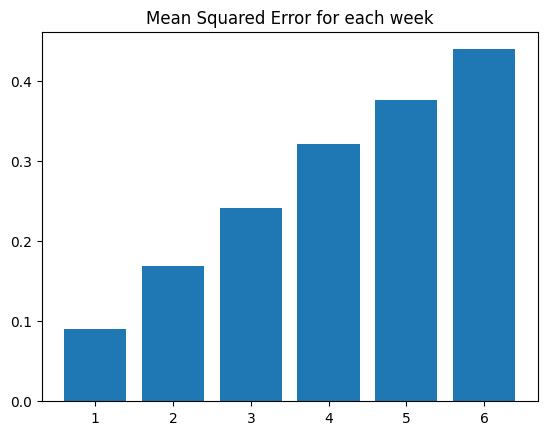

In [68]:
# MAE plot for each week
mse = []
for w in range(6):
    wdf = df[df['week']==w]
    mse.append(mean_squared_error(wdf['y_true'], wdf['y_pred']))
plt.bar(range(1,7), mse)
plt.title("Mean Squared Error for each week")

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, root_mean_squared_error
y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
# do a table using print in the terminal
print("  MAE  | RMSE  |  F1  ")
print(f"{mae} | {rmse} | {f1}")

  MAE  | RMSE  |  F1  
0.33332882523278495 | 0.5222084103006581 | 0.5470579977159161


In [70]:
y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
for i in range(len(y_pred_roc)):
    y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
for i in range(len(y_true_roc)):
    y_true_for_sklearn[i, int(y_true_roc[i])] = 1


mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')

results = pd.DataFrame({'Model': ["att_embeddings"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})
results

,Model,MAE,RMSE,F1,ROC_AUC
0,att_embeddings,0.333329,0.522208,0.547058,0.780156


(array([7.000e+00, 1.300e+01, 1.200e+01, 8.000e+00, 2.000e+01, 1.600e+01,
        3.500e+01, 4.100e+01, 5.200e+01, 1.040e+02, 1.260e+02, 1.530e+02,
        1.960e+02, 3.640e+02, 6.210e+02, 1.204e+03, 3.015e+03, 4.167e+03,
        7.390e+02, 7.150e+02, 6.370e+02, 5.600e+02, 5.710e+02, 4.780e+02,
        3.800e+02, 1.680e+02, 9.800e+01, 7.300e+01, 8.900e+01, 5.800e+01,
        5.400e+01, 3.000e+01, 1.300e+01, 1.700e+01, 1.000e+01, 9.000e+00,
        4.000e+00, 3.000e+00, 0.000e+00, 2.000e+00]),
 array([-2.37568521, -2.23885517, -2.10202513, -1.96519509, -1.82836505,
        -1.69153501, -1.55470497, -1.41787493, -1.28104489, -1.14421485,
        -1.00738481, -0.87055477, -0.73372473, -0.59689468, -0.46006464,
        -0.3232346 , -0.18640456, -0.04957452,  0.08725552,  0.22408556,
         0.3609156 ,  0.49774564,  0.63457568,  0.77140572,  0.90823576,
         1.04506581,  1.18189585,  1.31872589,  1.45555593,  1.59238597,
         1.72921601,  1.86604605,  2.00287609,  2.13970613,  2.2

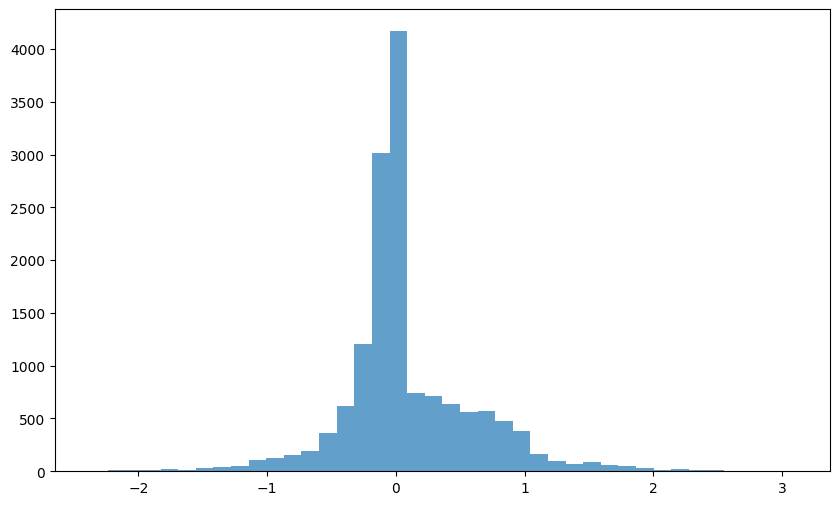

In [71]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

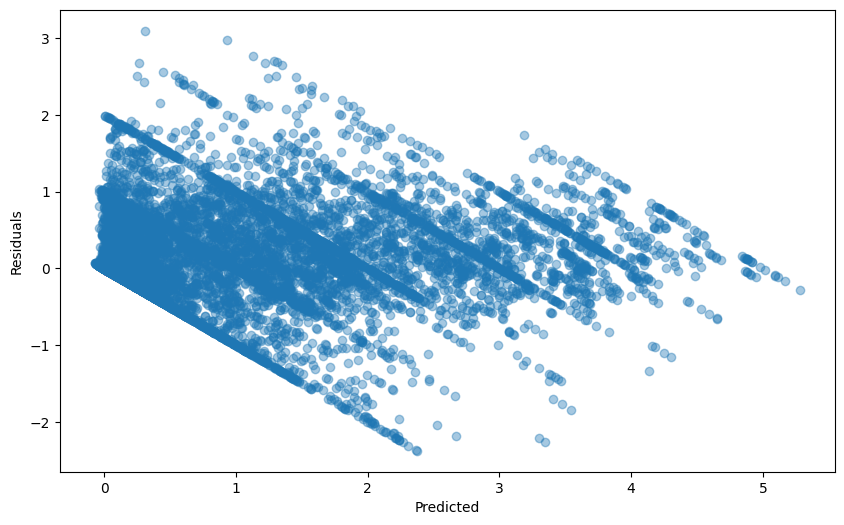

In [72]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

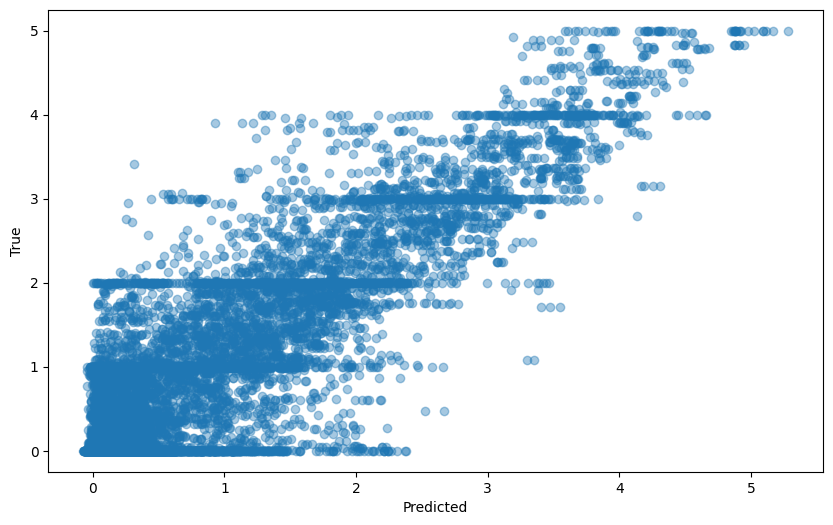

In [73]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")